In [ ]:
# PPO for Portfolio Optimization

import numpy as np
import pandas as pd
import yfinance as yf
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple
import random
import matplotlib.pyplot as plt
import datetime

In [ ]:
# --- 1. Data Preparation ---
data_filename = "prices.csv"
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]

if os.path.exists(data_filename):
    prices_df = pd.read_csv(data_filename, index_col=0, parse_dates=True)
else:
    df = yf.download(tickers, start="2019-01-01", end="2023-12-31", interval="1d")
    prices_df = df.xs('Close', axis=1, level='Price')
    prices_df.dropna(inplace=True)
    prices_df.to_csv(data_filename)

train_df = prices_df[prices_df.index < "2023-01-01"]
test_df = prices_df[prices_df.index >= "2023-01-01"]
train_prices = train_df.values
test_prices = test_df.values
num_assets = train_prices.shape[1]


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


In [ ]:
# --- 2. State/Action Representation ---
def encode_state(increments):
    return "".join(chr(ord('A') + inc) for inc in increments)

def decode_state(state_str):
    return tuple(ord(ch) - ord('A') for ch in state_str)

actions = [(i, j) for i in range(num_assets) for j in range(num_assets) if i != j]
actions.append((None, None))

def get_valid_actions(state):
    increments = decode_state(state) if isinstance(state, str) else state
    valid = []
    for (i, j) in actions:
        if i is None and j is None:
            valid.append((None, None))
            continue
        if i is None or j is None:
            continue
        if increments[i] >= 1 and increments[j] <= 19:
            valid.append((i, j))
    return valid

def apply_action(state, action):
    increments = list(state)
    if action == (None, None):
        return tuple(increments)
    i, j = action
    if increments[i] >= 1 and increments[j] <= 19:
        increments[i] -= 1
        increments[j] += 1
    return tuple(increments)

def compute_reward(weight_frac, price_today, price_next):
    growth = sum(weight_frac[k] * (price_next[k] / price_today[k]) for k in range(num_assets))
    return math.log(growth)


In [ ]:
# --- 3. PPO Networks (Actor-Critic with shared base) ---
class ActorCritic(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.actor(x), self.critic(x)

In [ ]:
# --- 4. PPO Training Setup ---
Transition = namedtuple('Transition', ['state', 'action', 'log_prob', 'reward', 'next_state', 'done'])
def state_to_tensor(state):
    return torch.tensor([x / 20.0 for x in state], dtype=torch.float32)

def action_to_index(action):
    return actions.index(action)

def index_to_action(index):
    return actions[index]

model = ActorCritic(5, len(actions))
optimizer = optim.Adam(model.parameters(), lr=3e-4)

gamma = 0.99
clip_eps = 0.2
ppo_epochs = 4
batch_size = 64
episodes = 100
initial_state = (4, 4, 4, 4, 4)

In [ ]:
# --- 5. PPO Training Loop ---
all_rewards = []
for ep in range(episodes):
    state = initial_state
    log = []
    rewards_ep = 0

    for t in range(train_prices.shape[0] - 1):
        s_tensor = state_to_tensor(state)
        probs, value = model(s_tensor)
        valid_acts = get_valid_actions(state)
        valid_idxs = [action_to_index(a) for a in valid_acts]
        filtered_probs = probs[valid_idxs]
        filtered_probs /= filtered_probs.sum()
        dist = torch.distributions.Categorical(filtered_probs)
        act_idx = valid_idxs[dist.sample().item()]
        action = index_to_action(act_idx)

        next_state = apply_action(state, action)
        weights_new = [x / 20.0 for x in next_state]
        reward = compute_reward(weights_new, train_prices[t], train_prices[t + 1])
        rewards_ep += reward

        log_prob = torch.log(probs[act_idx])
        log.append(Transition(state, act_idx, log_prob, reward, next_state, False))
        state = next_state

    all_rewards.append(rewards_ep)

In [ ]:
    # --- 6. PPO Update ---
    states = torch.stack([state_to_tensor(tr.state) for tr in log])
    actions_tensor = torch.tensor([tr.action for tr in log])
    old_log_probs = torch.stack([tr.log_prob for tr in log])
    rewards = [tr.reward for tr in log]

    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)

    for _ in range(ppo_epochs):
        new_probs, values = model(states)
        dist = torch.distributions.Categorical(new_probs)
        new_log_probs = dist.log_prob(actions_tensor)

        ratio = torch.exp(new_log_probs - old_log_probs.detach())
        advantage = returns - values.squeeze()

        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * advantage
        actor_loss = -torch.min(surr1, surr2).mean()
        critic_loss = advantage.pow(2).mean()

        loss = actor_loss + 0.5 * critic_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Episode {ep + 1}, Total Reward: {rewards_ep:.4f}")

Episode 100, Total Reward: 0.5418


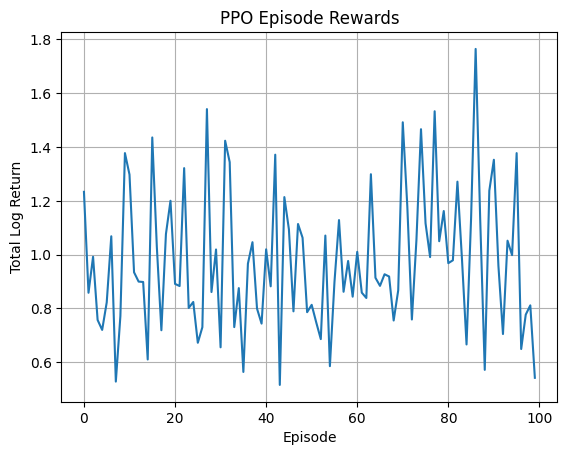

In [ ]:
# --- 7. Plot PPO Training Rewards ---
plt.plot(all_rewards)
plt.title("PPO Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Log Return")
plt.grid(True)
plt.show()


In [ ]:
# --- 8. ROI, Sharpe Ratio, CAGR ---
# Simulate test performance
state = initial_state
portfolio_value_rl = [1.0]
log_returns = []

for t in range(test_prices.shape[0] - 1):
    s_tensor = state_to_tensor(state)
    with torch.no_grad():
        probs, _ = model(s_tensor)
    valid_acts = get_valid_actions(state)
    valid_idxs = [action_to_index(a) for a in valid_acts]
    filtered_probs = probs[valid_idxs]
    filtered_probs /= filtered_probs.sum()
    dist = torch.distributions.Categorical(filtered_probs)
    act_idx = valid_idxs[dist.sample().item()]
    action = index_to_action(act_idx)

    next_state = apply_action(state, action)
    weights_new = [x / 20.0 for x in next_state]
    reward = compute_reward(weights_new, test_prices[t], test_prices[t + 1])
    log_returns.append(reward)
    portfolio_value_rl.append(portfolio_value_rl[-1] * math.exp(reward))
    state = next_state

# Metrics
initial_value = portfolio_value_rl[0]
final_value = portfolio_value_rl[-1]
daily_returns = np.exp(log_returns) - 1
average_return = np.mean(daily_returns)
volatility = np.std(daily_returns)
sharpe_ratio = (average_return / volatility) * np.sqrt(252)
days = len(portfolio_value_rl) - 1
roi = (final_value - initial_value) / initial_value
cagr = (final_value / initial_value) ** (252 / days) - 1

print(f"\nSharpe Ratio on Test Set (RL Portfolio): {sharpe_ratio:.4f}")
print(f"Return on Investment (RL Portfolio): {roi * 100:.2f}%")
print(f"Compound Annual Growth Rate (CAGR): {cagr * 100:.2f}%")


Sharpe Ratio on Test Set (RL Portfolio): 2.2522
Return on Investment (RL Portfolio): 83.12%
Compound Annual Growth Rate (CAGR): 84.46%


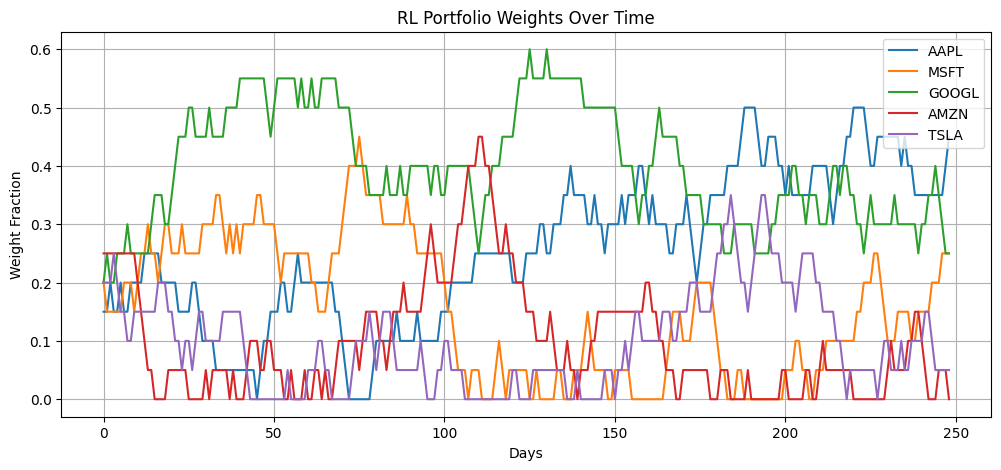

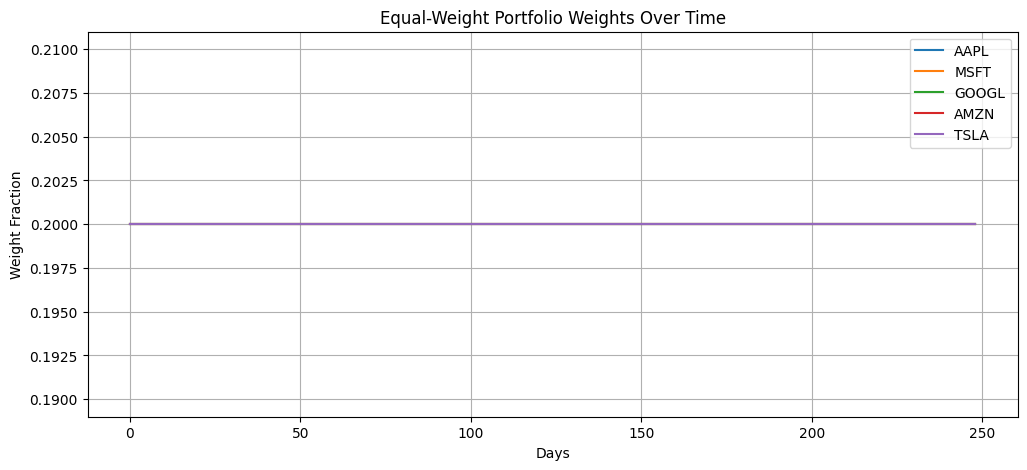

In [ ]:
# --- 9. Portfolio Weights Over Time (RL vs Equal Weight) ---
weights_over_time_rl = []
weights_equal = [1.0 / num_assets] * num_assets
weights_over_time_eq = [weights_equal] * (test_prices.shape[0] - 1)

state = initial_state
for t in range(test_prices.shape[0] - 1):
    s_tensor = state_to_tensor(state)
    with torch.no_grad():
        probs, _ = model(s_tensor)
    valid_acts = get_valid_actions(state)
    valid_idxs = [action_to_index(a) for a in valid_acts]
    filtered_probs = probs[valid_idxs]
    filtered_probs /= filtered_probs.sum()
    dist = torch.distributions.Categorical(filtered_probs)
    act_idx = valid_idxs[dist.sample().item()]
    action = index_to_action(act_idx)

    next_state = apply_action(state, action)
    weights_new = [x / 20.0 for x in next_state]
    weights_over_time_rl.append(weights_new)
    state = next_state

weights_df_rl = pd.DataFrame(weights_over_time_rl, columns=tickers)
weights_df_eq = pd.DataFrame(weights_over_time_eq, columns=tickers)

weights_df_rl.plot(figsize=(12, 5), title="RL Portfolio Weights Over Time")
plt.ylabel("Weight Fraction")
plt.xlabel("Days")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

weights_df_eq.plot(figsize=(12, 5), title="Equal-Weight Portfolio Weights Over Time")
plt.ylabel("Weight Fraction")
plt.xlabel("Days")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

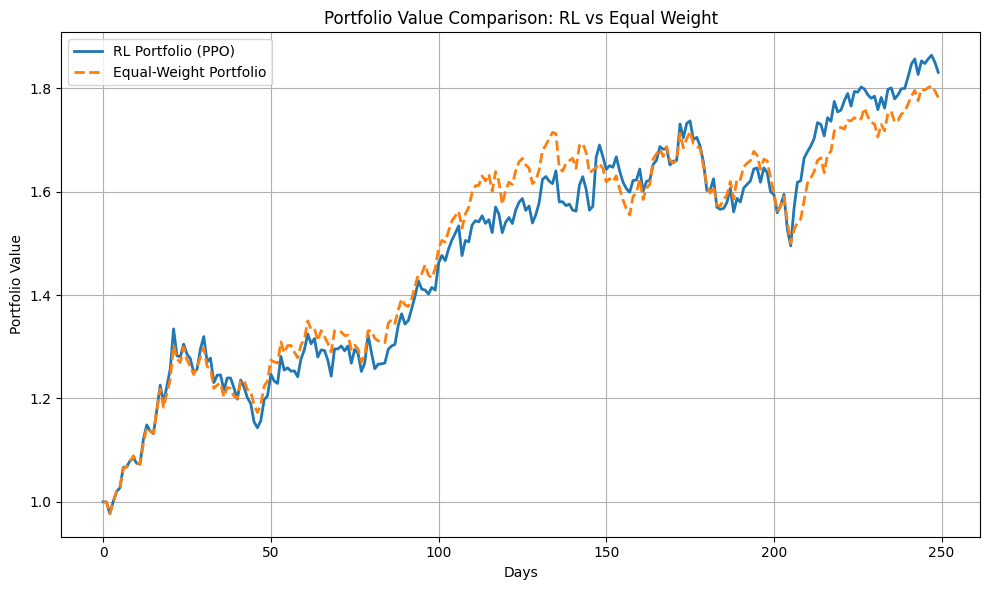

In [ ]:
# ---10. Comparison of Portfolio Value: RL vs Equal Weight ---

portfolio_value_eq = [1.0]
weights_equal = [1.0 / num_assets] * num_assets
for t in range(test_prices.shape[0] - 1):
    reward_eq = compute_reward(weights_equal, test_prices[t], test_prices[t + 1])
    portfolio_value_eq.append(portfolio_value_eq[-1] * math.exp(reward_eq))

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value_rl, label="RL Portfolio (PPO)", linewidth=2)
plt.plot(portfolio_value_eq, label="Equal-Weight Portfolio", linestyle="--", linewidth=2)
plt.title("Portfolio Value Comparison: RL vs Equal Weight")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
